In [12]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

In [13]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [54]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.1,
    #featurewise_center=True,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    brightness_range=[0.90,1.25],
    #fill_mode='nearest'
)

In [67]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=True,
    color_mode='rgb'
)


# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32, 
    shuffle=False,
    #color_mode='rgb'
)


# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False,
    #color_mode='rgb'
)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 151.0610 and the minimum is -123.6800
The mean value of the pixels is -23.1977 and the standard deviation is 88.1978


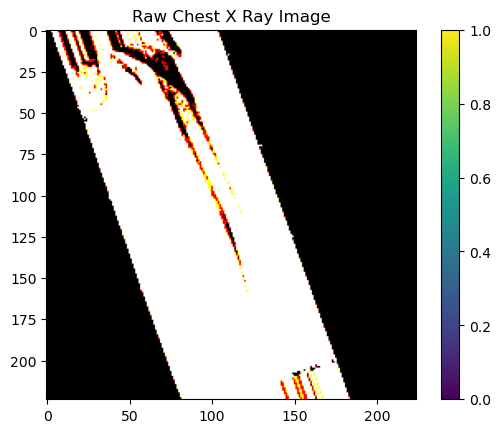

In [59]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(20)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [60]:
generated_image.shape

(32, 224, 224, 3)

In [61]:
pre_trained_model_resnet152 = ResNet152(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

In [62]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_resnet152.layers:
    layer.trainable=False

tf.random.set_seed(150)

model = tf.keras.models.Sequential([
    pre_trained_model_resnet152,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    # Dense(256,activation="relu"),
    # Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 59,485,825
Trainable params: 1,114,881
Non-trainable params: 58,370,944
__________________________________

In [64]:
# from sklearn.utils import class_weight
# weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
# dict_weights = {0: weights[0], 1:weights[1]}
# dict_weights

In [66]:
history = model.fit( train_data, 
validation_data= val_data, 
epochs= 8, 
verbose=1, 
#class_weight=dict_weights
)

Epoch 1/8
82/82 [==============================] - 415s 5s/step - loss: 5120182495234195.0000 - accuracy: 0.6457 - val_loss: nan - val_accuracy: 0.4241
Epoch 2/8
82/82 [==============================] - 403s 5s/step - loss: 0.6879 - accuracy: 0.6578 - val_loss: 0.6746 - val_accuracy: 0.7989
Epoch 3/8
82/82 [==============================] - 403s 5s/step - loss: 0.6700 - accuracy: 0.8013 - val_loss: 0.6569 - val_accuracy: 0.7989
Epoch 4/8
82/82 [==============================] - 402s 5s/step - loss: 0.6538 - accuracy: 0.7905 - val_loss: 0.6405 - val_accuracy: 0.7989
Epoch 5/8
82/82 [==============================] - 403s 5s/step - loss: 0.6349 - accuracy: 0.8071 - val_loss: 0.6253 - val_accuracy: 0.7989
Epoch 6/8
82/82 [==============================] - 405s 5s/step - loss: 0.6212 - accuracy: 0.7998 - val_loss: 0.6109 - val_accuracy: 0.7989
Epoch 7/8
82/82 [==============================] - 405s 5s/step - loss: 0.6097 - accuracy: 0.7916 - val_loss: 0.5975 - val_accuracy: 0.7989
Epoch 8/

In [68]:
model.evaluate(test_data)

864/864 [==============================] - 151s 175ms/step - loss: 0.5848 - accuracy: 0.7998


[0.5848277807235718, 0.7997685074806213]

: 